In [1]:
#import statements
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import shutil
import csv
import pandas as pd
import PIL
from sympy import *
from skimage import color
from skimage import morphology
from scipy import stats
from scipy import ndimage
import statistics
import cv2
from skimage import filters
import math

In [3]:
print(os.getcwd())
df = pd.read_csv("C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\annotations\\info.csv", usecols = ["File_name", "Measurement_coordinates", "Possibly_noisy", "Train_Val_Test"])
def roundInt(x):
    x = int(x+0.5)
    if x > 512:
        x = 512
    if x < 0:
        x = 0
    return x

np.set_printoptions(threshold=50000)

C:\Temp\nitish\Tensorflow\workspace\training_demo\images


Threshold of 0: 56.27618045398034
Difference of 0: 79.8906223760714
Variance of 0: 205.66439909297054
Threshold of 1: 64.39977208094749
Difference of 1: 107.04513370883797
Variance of 1: 155.5555555555556
Threshold of 2: 55.96205886360312
Difference of 2: 94.62929469240044
Variance of 2: 97.33931737030035
Threshold of 3: 59.19518939341418
Difference of 3: 110.0749292175824
Variance of 3: 53.75993237531699
Threshold of 4: 75.25400688284334
Difference of 4: 141.02911144340032
Variance of 4: 109.06083333333332
Threshold of 5: 24.664663875011527
Difference of 5: 1.7219575112103485
Variance of 5: 199.1875
Threshold of 6: 43.12139065446447
Difference of 6: 26.681225077118143
Variance of 6: 371.5972222222222
Threshold of 7: 114.09603289402952
Difference of 7: 120.774484681373
Variance of 7: 1230.966264056643
Threshold of 8: 52.834309485359704
Difference of 8: 71.08398890068929
Variance of 8: 207.19234375000005


c:\program files\python\python36\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


'\n#printing of relevant statistics\nprint(str(statistics.median(thresholds)))\nprint("Minimum variance: " + str(min(variance_array)))\nprint("Maximum variance: " + str(max(variance_array)))\nprint("Median variance: " + str(statistics.median(variance_array)))\nprint("IQR variance: " + str(stats.iqr(variance_array)))\nprint("Maximum variance: " + str(np.amax(variance_array)))\nprint("Stdev variance: " + str(np.std(variance_array)))\n\nprint("Minimum difference: " + str(min(avg_mode_diff_array)))\nprint("Maximum difference: " + str(max(avg_mode_diff_array)))\nprint("Median difference: " + str(statistics.median(avg_mode_diff_array)))\nprint("IQR difference: " + str(stats.iqr(avg_mode_diff_array)))\nprint("Maximum difference: " + str(np.amax(avg_mode_diff_array)))\nprint("Stdev difference: " + str(np.std(avg_mode_diff_array)))\nprint(str(np.mean(avg_mode_diff_array)))\nq = [(x*np.std(variance_array) + np.mean(variance_array)) for x in np.linspace(-0.3,1.5,1250)]\nr = [(m*np.std(avg_mode_di

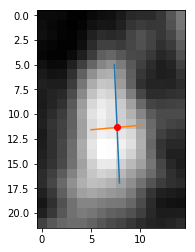

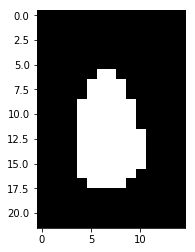

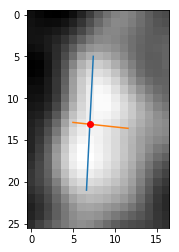

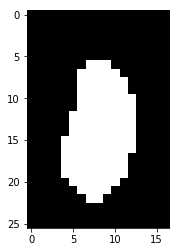

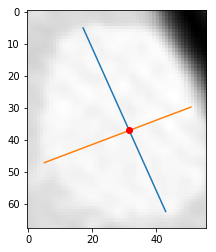

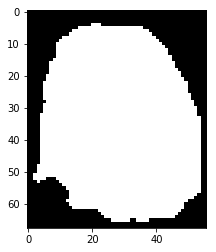

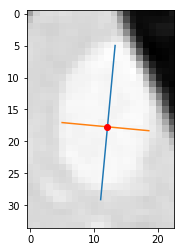

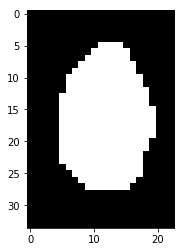

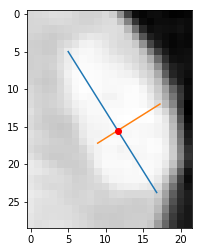

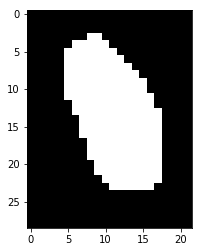

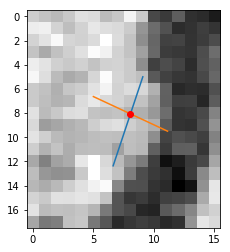

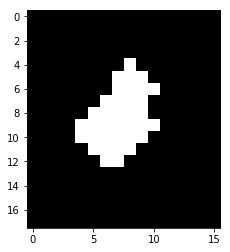

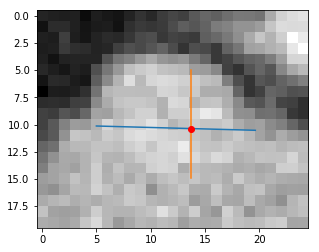

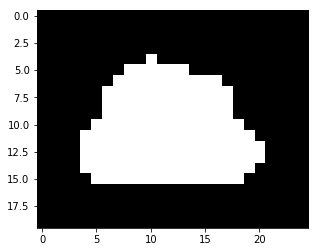

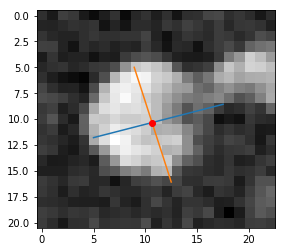

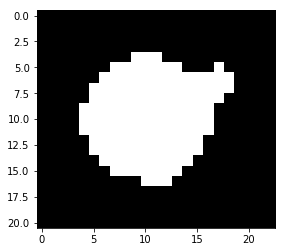

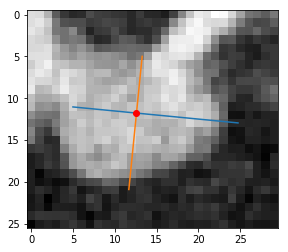

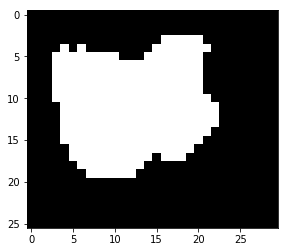

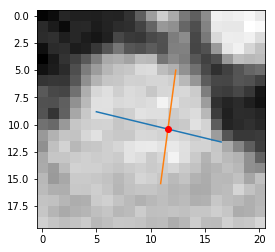

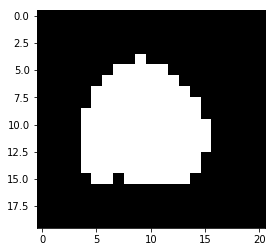

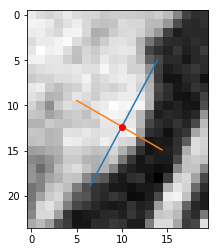

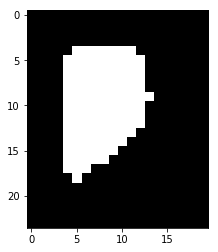

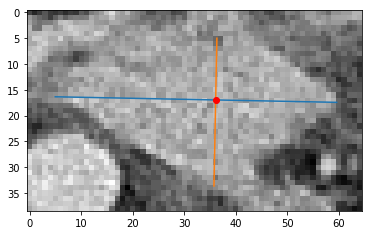

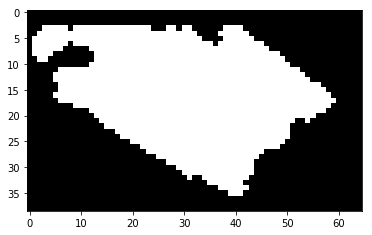

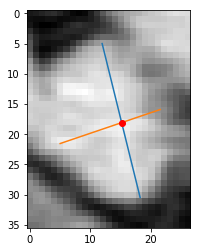

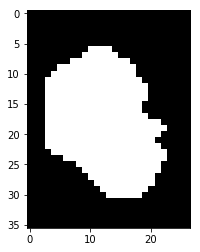

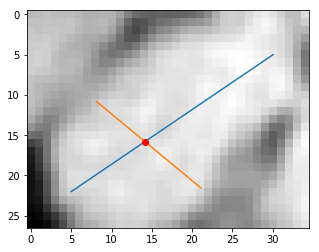

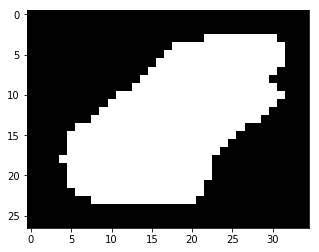

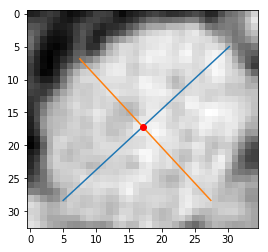

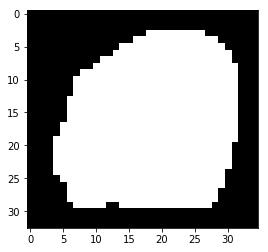

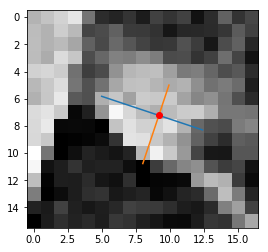

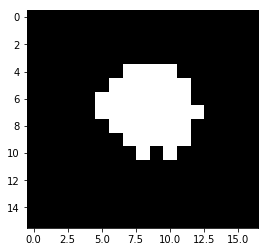

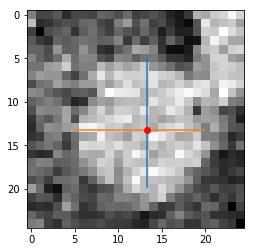

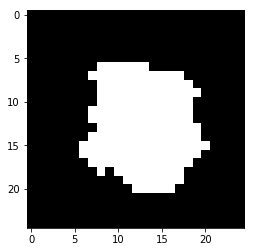

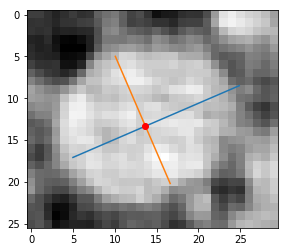

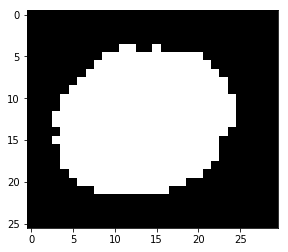

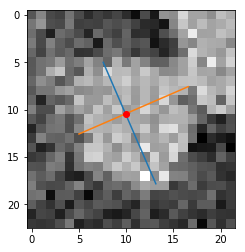

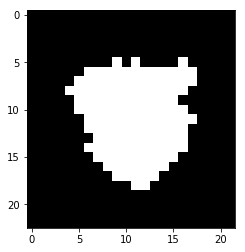

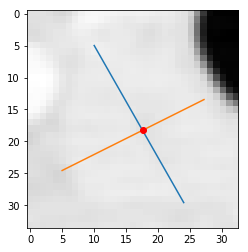

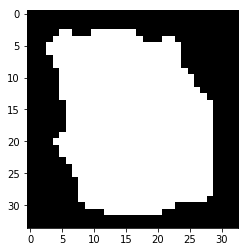

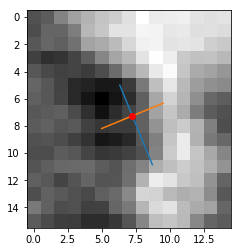

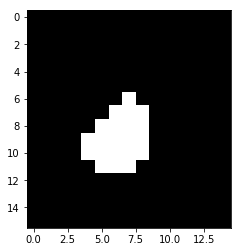

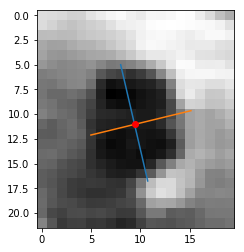

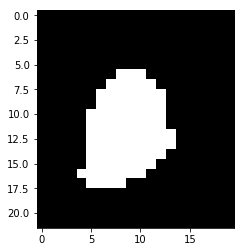

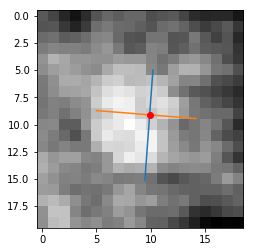

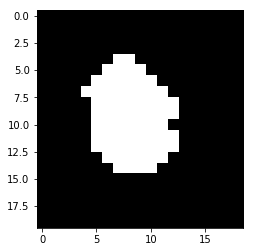

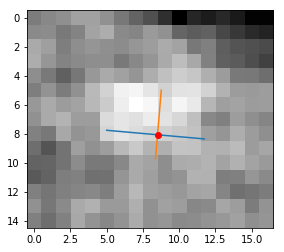

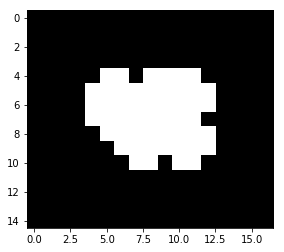

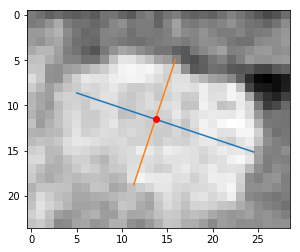

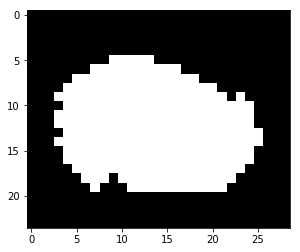

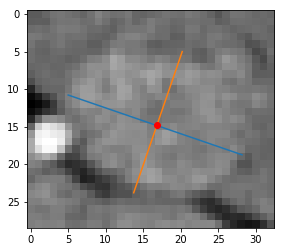

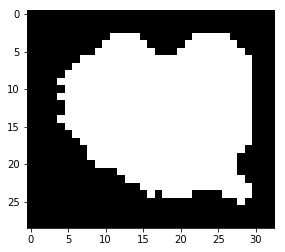

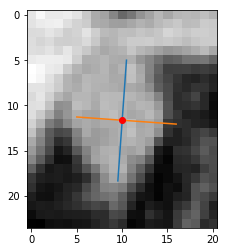

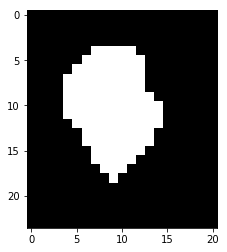

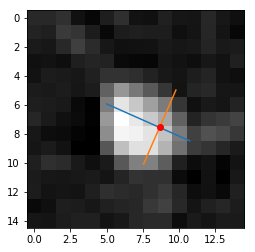

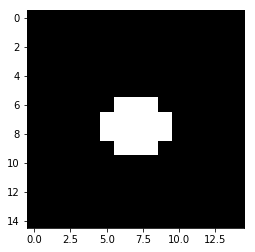

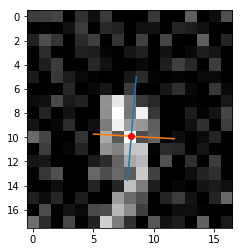

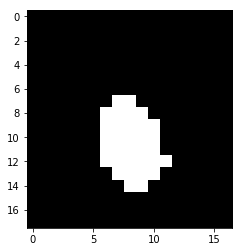

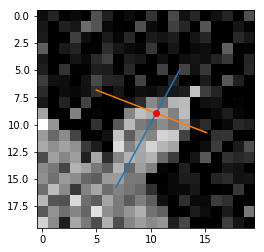

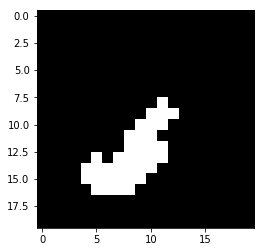

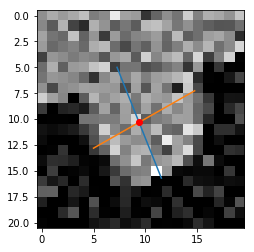

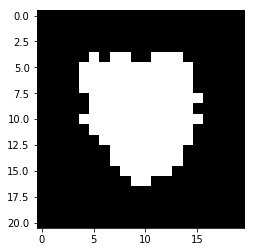

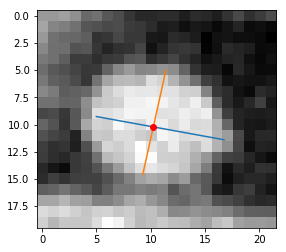

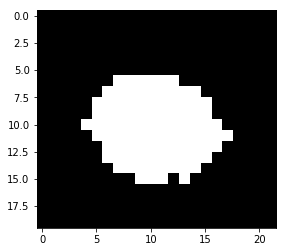

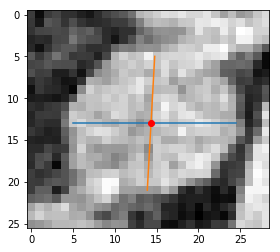

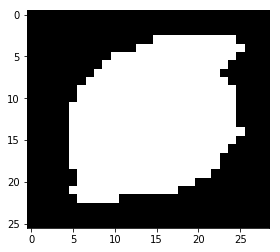

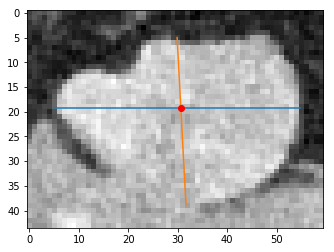

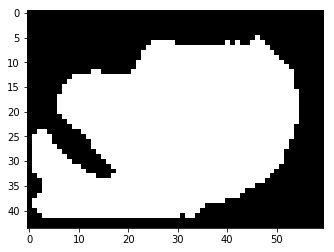

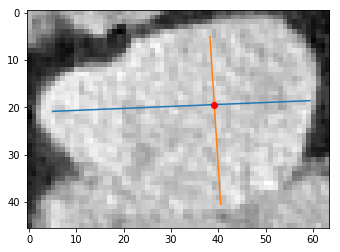

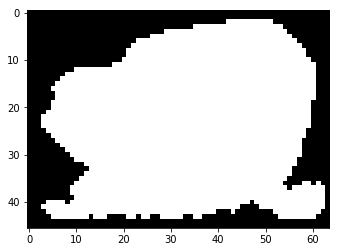

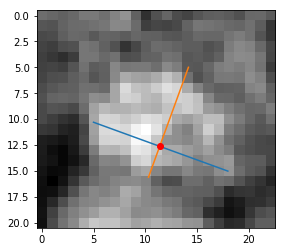

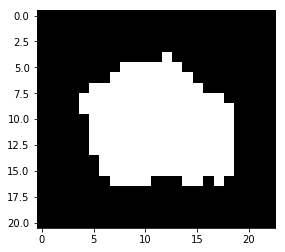

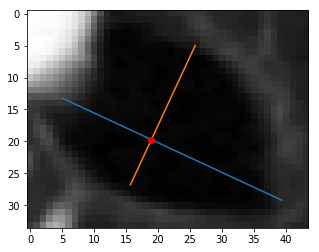

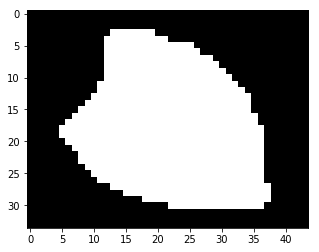

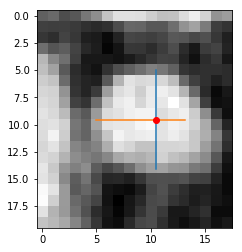

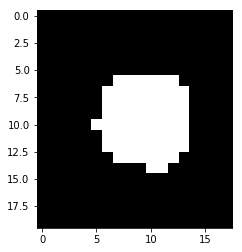

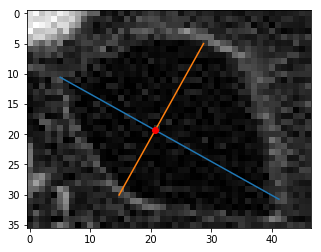

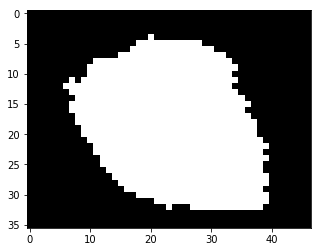

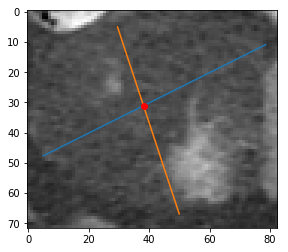

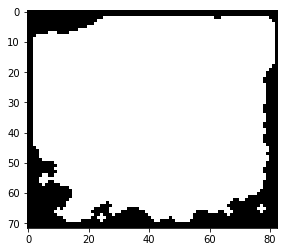

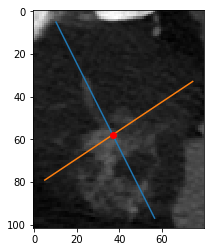

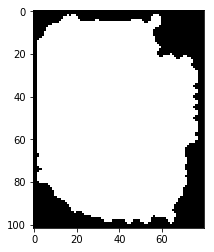

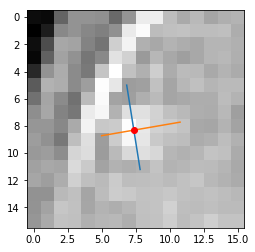

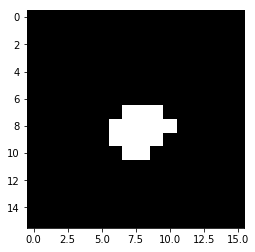

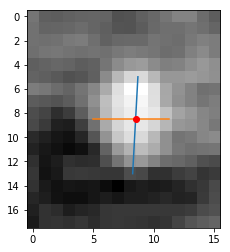

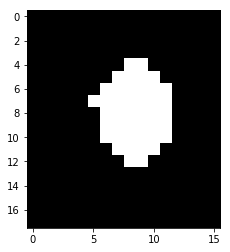

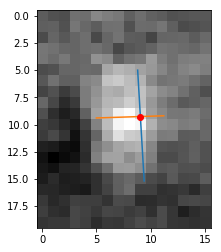

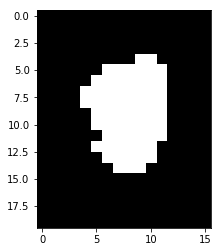

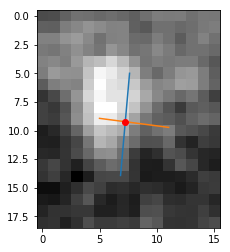

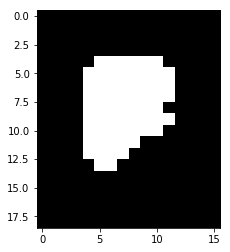

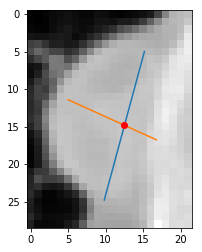

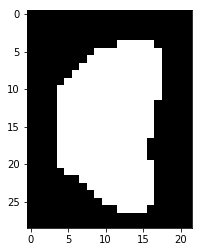

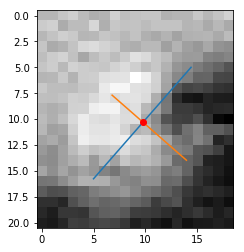

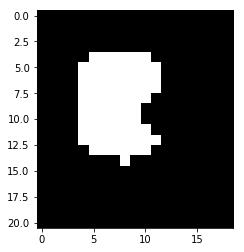

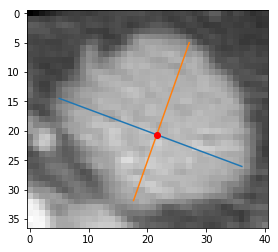

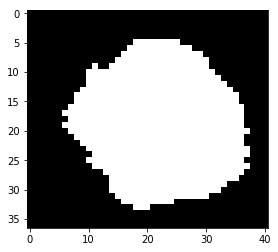

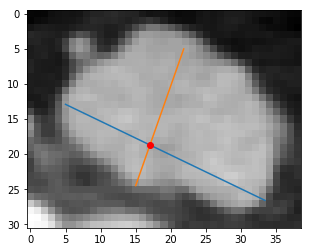

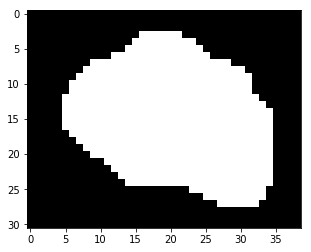

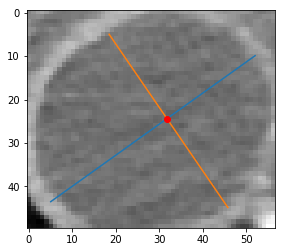

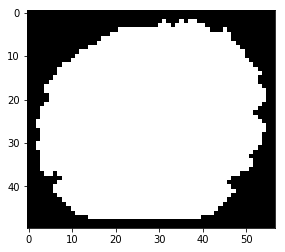

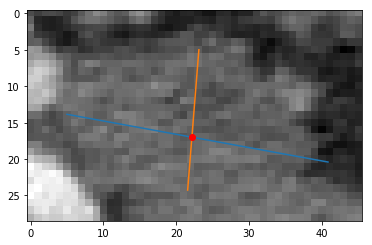

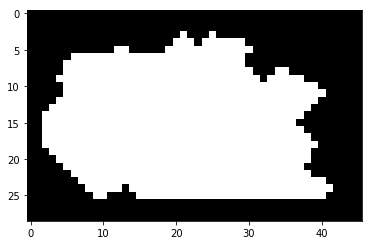

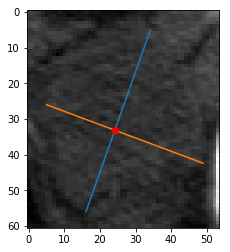

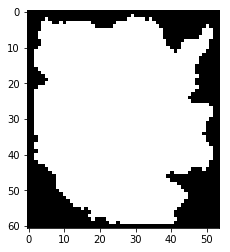

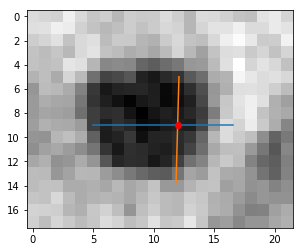

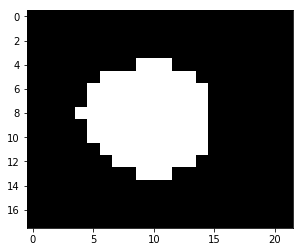

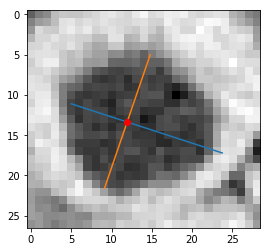

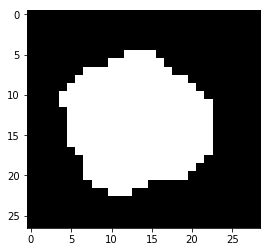

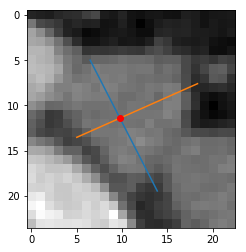

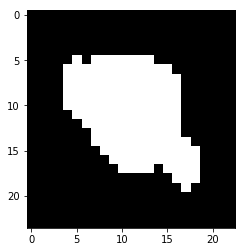

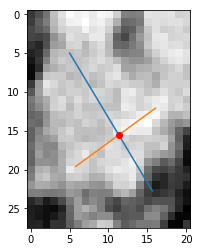

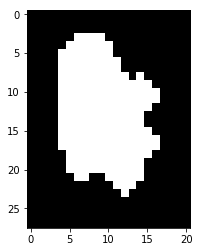

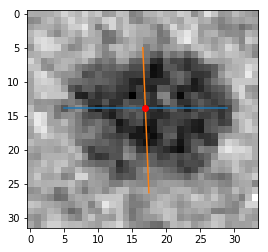

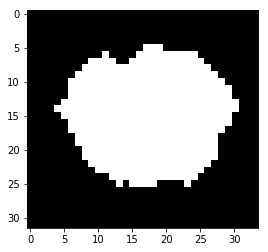

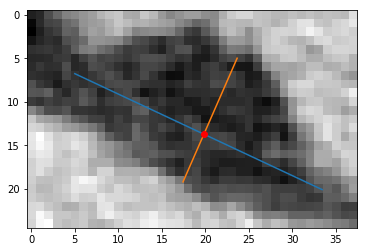

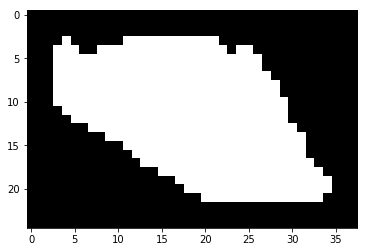

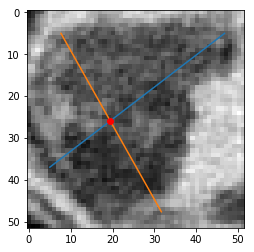

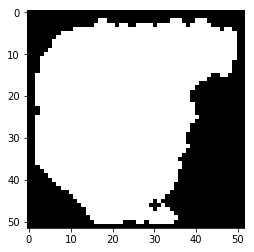

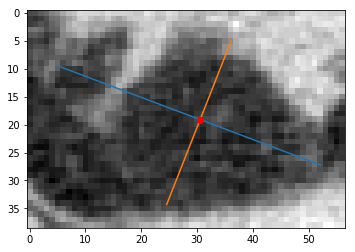

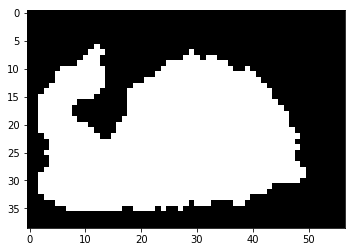

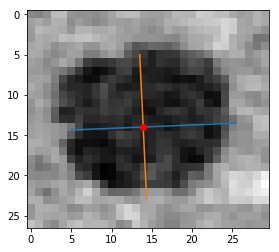

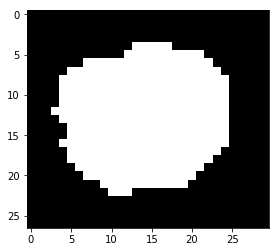

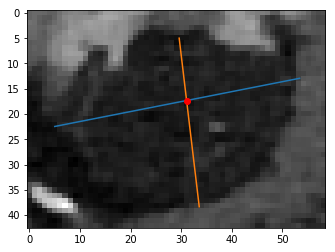

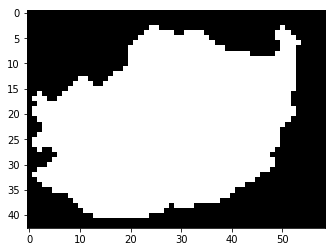

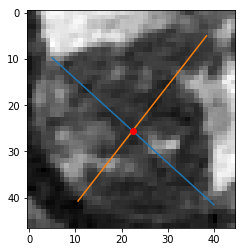

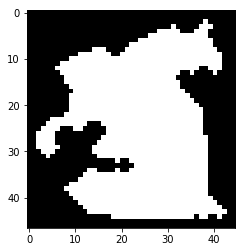

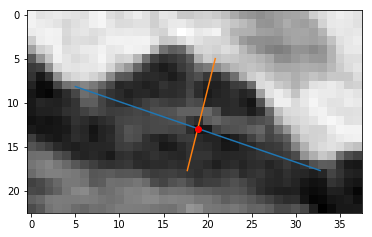

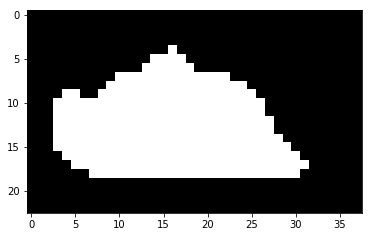

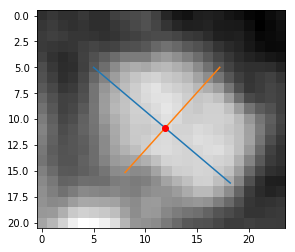

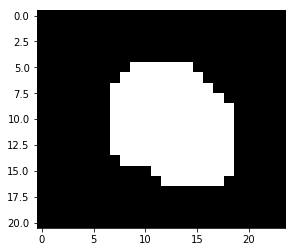

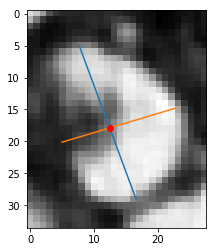

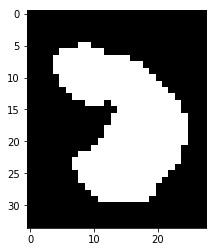

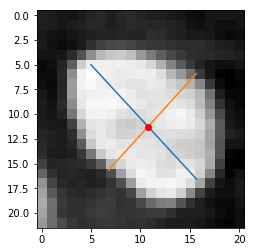

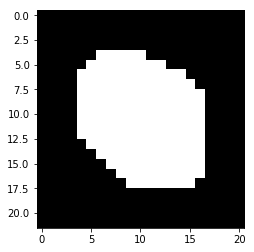

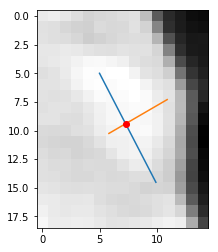

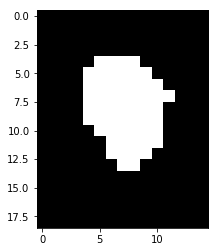

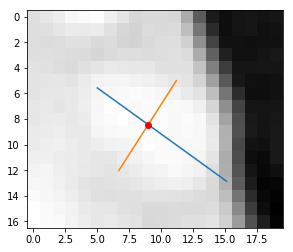

In [25]:
base = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\Selected\\"

#data storage arrays
variance_array = []
avg_mode_diff_array = []
thresholds = []
count = 0
#iterate through image dataset
for i, rows in enumerate(df.values):
    
    if count == 250:
        break
        
    count += 1    
    #validate lossiness
    
    
    
    if df["Possibly_noisy"][i] == 0:
        
        
        #load image
        x,y = rows[0].split(".")
        a,b,c,d = x.split("_")
        folder_name = a + "_" + b + "_" + c + "\\"
        file_name = d + "." + y
        file_location = base + folder_name + file_name
        os.chdir(base + folder_name)
        im = PIL.Image.open(file_name)
        
        #load diameter location
        raw_pixels = np.asarray(df["Measurement_coordinates"][i].split(","))
        x_values = raw_pixels[0:7:2].astype(np.float)
        y_values = raw_pixels[1:8:2].astype(np.float)
        raw_pixels = np.reshape(raw_pixels, (4,2))
        raw_pixels = raw_pixels.astype(np.float)
        xmax = np.amax(x_values)
        xmin = np.amin(x_values)
        ymax = np.amax(y_values)
        ymin = np.amin(y_values)

        
        #generate lines
        
        x1_index = np.where(x_values == xmin)[0][0]

        p1x = Point(x_values[x1_index], y_values[x1_index])
        x2_index = np.where(x_values == xmax)[0][0]
        p2x = Point(x_values[x2_index], y_values[x2_index])

    
    
        y1_index = np.where(y_values == ymin)[0][0]
        p1y = Point(x_values[y1_index], y_values[y1_index])
        y2_index = np.where(y_values == ymax)[0][0]
        p2y = Point(x_values[y2_index], y_values[y2_index])

            
    
        solutions = np.zeros(2)
        
        
        #calculate diameter intersection
        
        line1 = Line(Point(x_values[0],y_values[0]), Point(x_values[1],y_values[1]))
        line2 = Line(Point(x_values[2],y_values[2]), Point(x_values[3],y_values[3]))
        line1_coeff = np.asarray(list(line1.coefficients)).astype(np.float)
        line2_coeff = np.asarray(list(line2.coefficients)).astype(np.float)
        solutions = np.array([-1*line1_coeff[2], -1*line2_coeff[2]])
        line1_coeff = np.delete(line1_coeff, 2)
        line2_coeff = np.delete(line2_coeff, 2)
        b = np.array([line1_coeff, line2_coeff])
        row_sol, col_sol = np.linalg.lstsq(b, solutions, rcond = None)[0]
        center = Point(row_sol, col_sol)
        
        
        #extract midpoints
        
        x_min_midpoint = center.midpoint(p1x)
        #x_min_boundary = center.midpoint(x_min_midpoint)
        x_max_midpoint = center.midpoint(p2x)
        #x_max_boundary = center.midpoint(x_max_midpoint)
        y_min_midpoint = center.midpoint(p2y)
        #y_min_boundary = center.midpoint(y_min_midpoint)
        y_max_midpoint = center.midpoint(p1y)
        #y_max_boundary = center.midpoint(y_max_midpoint)

    
    
        #create sampling region
        x_start = roundInt(x_min_midpoint.x)
        x_end = roundInt(x_max_midpoint.x)
        if x_end - x_start < 1:
            x_end = x_end + 1
        y_start = roundInt(y_min_midpoint.y)
        y_end = roundInt(y_max_midpoint.y)
        if y_end - y_start < 1:
            y_start = y_start + 1
        
        im_array = np.array(im)

        im_array = color.rgb2gray(im_array)
    
    
        #calculate median of pixel intensity inside lesion region

        lesionMedian = stats.mstats.hdmedian(im_array[y_end:y_start:1, x_start: x_end:1], axis = None)
        
        #calculate variance of pixel intensities
        if np.ma.is_masked(lesionMedian):
            lesionMedian = im_array[y_end:y_start:1, x_start: x_end:1][0][0]
    
        variance = np.var(im_array[y_end:y_start:1, x_start: x_end:1], axis = None)
        
        
        #construct boundary for cutting lesion mask
        
        bound = 5
        relBound = 0.1
        rbh = roundInt((ymax - ymin)*relBound)+2
        rbw = roundInt((xmax - xmin)*relBound)+2
        height = roundInt(ymax-ymin)
        if height == 0:
            height = 1
            
        width = roundInt(xmax - xmin)
        if width == 0:
            width = 1

        
        
        #relatively constructed lesion boxes
        
        
        relativeLesionBox = im_array[(roundInt(ymin)-rbh):(roundInt(ymax)+rbh):1, (roundInt(xmin)-rbw):(roundInt(xmax)+rbw):1]
        smallLesionBox = im_array[roundInt(ymin):(roundInt(ymin + height)):1, roundInt(xmin):(roundInt(xmin + width)):1]
        lesionBox = im_array[roundInt(ymin-bound):roundInt(ymax+bound):1, roundInt(xmin-bound):roundInt(xmax+bound):1]
        
        plt.imshow(lesionBox, cmap='gray')
        #plotting code
        
        """
        x_values[0] -= (xmin - bound)
        x_values[1] -= (xmin - bound)
        y_values[0] -= (ymin - bound)
        y_values[1] -= (ymin - bound)
        plt.plot(x_values[0:2], y_values[0:2])
        
        x_values[2] -= (xmin - bound)
        x_values[3] -= (xmin - bound)
        y_values[2] -= (ymin - bound)
        y_values[3] -= (ymin - bound)
        plt.plot(x_values[2:4], y_values[2:4])
        
        centerx = center.x - (xmin - bound)
        centery = center.y - (ymin - bound)
        plt.plot(centerx, centery, 'ro')
        """
        
        #determine bimodality
        
        if variance > 5000 and not((smallLesionBox == smallLesionBox[0][0]).all()):
            split = filters.threshold_otsu(smallLesionBox)
            lowDS = np.extract(smallLesionBox < split, smallLesionBox)
            highDS = np.extract(smallLesionBox > split, smallLesionBox)

            val = np.var(lowDS) + np.var(highDS)
            
            
            #if bimodal, recalculate variance and median 
            
            if val  < 55000:

                lowCount = np.count_nonzero(smallLesionBox < split)
                highCount = np.count_nonzero(smallLesionBox > split)
                if lowCount > highCount:
                    variance = np.var(lowDS)
                    lesionMedian = stats.mstats.hdmedian(lowDS, axis = None)
                else:
                    variance = np.var(highDS)
                    lesionMedian = stats.mstats.hdmedian(highDS, axis = None)
        
      
        
        #Find minimum difference in intensity from top, bottom, left, and right
    
        r, c = relativeLesionBox.shape
        
        mol= np.median(relativeLesionBox[:, :rbw:1])
        difference1 = abs(lesionMedian - mol)
        
        
        length1 = roundInt((xmax - xmin)+rbw)
        if length1 > c:
            length1 = c
        
        mor= np.median(relativeLesionBox[:, length1::1])
        difference2 = abs(lesionMedian - mor)
   
        mot= np.median(relativeLesionBox[:rbh:1, :]) 
        difference3 = abs(lesionMedian - mot)
        
        length2 = roundInt((ymax-ymin)+rbh)
        if length2 > r:
            length2 = r
        
        mob= np.median(relativeLesionBox[length2::1, :])
        difference4 = abs(lesionMedian - mob)
        
        differences = np.array([difference1,difference2,difference3,difference4])
        
        avg_mode_diff = np.nanmin(differences)

            
        h, w = smallLesionBox.shape
        isLarge = h > 70 or w > 70

        
        #adjusting outlying differences and variances
        
        if avg_mode_diff > 250:
            avg_mode_diff = 22.5*sqrt(avg_mode_diff - 127)

        if variance > 1500:

            variance = (variance - 1500)**0.68 + 1500

    
        diff = np.empty([roundInt(2*bound+ymax-ymin), roundInt(2*bound+xmax-xmin)])
         
            
        #creating slack for clipping    
        xSlack = roundInt(0.06*(xmax - xmin + 2*bound))
        ySlack = roundInt(0.06*(ymax - ymin + 2*bound))
        finalx = bound-xSlack
        if finalx < 0:
            finalx = 0
        finaly = bound-ySlack
        if finaly < 0:
            finaly = 0
        
        
        #if lesion is large, slack is different, and variance is adjusted
        if isLarge:
            xSlack = 3
            ySlack = 3
            finaly = bound-3
            finalx = bound-3
            variance = variance/2.5
        

        #FINAL THRESHOLD EQUATION
        threshold = 0.4*avg_mode_diff + 0.25*(variance**0.76) + 10
        
        #threshold adjustments for outlying values
        if variance > 1500 and avg_mode_diff < 65:
            threshold = threshold ** 0.85

        if avg_mode_diff < 5 and variance > 100:
            threshold += 5
        if avg_mode_diff < 20 and variance < 200:
            threshold -= 5
        if threshold > 600:
            threshold = ((threshold - 600)**0.95) + 600
        if threshold < 0: 
            threshold = 5
            
        #construct mask from threshold    
            
        diff = abs(lesionBox - lesionMedian) < threshold
        
        diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
        diff[:, :finalx] = False
        diff[:finaly, :] = False
        diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False

        
        #apply morphological operations
        
        area = 0.3*((ymax - ymin)*(xmax - xmin))
        diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)
        diff = ndimage.binary_fill_holes(diff).astype(int)
        if area > 0:
            diff = ndimage.binary_opening(diff).astype(int)
        diff = ndimage.binary_closing(diff).astype(int)
        
        
        
        #iteratively increase threshold for masks that are blank
        
        varianceFactor = 40
        
        if variance > 3000:
            varianceFactor = 140
            
        if (np.count_nonzero(diff)/(h*w)) < 0.3:

            for n in range(0,50):
                threshold += 15
                
                diff = abs(lesionBox - lesionMedian) < threshold
                
                diff[:, (roundInt((xmax - xmin) + bound)):] = False #if this no work, then add some variable number(20% slack??)
                diff[:, :bound] = False
                diff[:bound, :] = False
                diff[(roundInt((ymax-ymin) + bound)):, :] = False

                area = 0.3*((ymax - ymin)*(xmax - xmin))
                diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)

                diff = ndimage.binary_erosion(diff).astype(int)
                
                if diff.any():
                    threshold += varianceFactor
                    diff = abs(lesionBox - lesionMedian) < threshold
                
                    diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
                    diff[:, :finalx] = False
                    diff[:finaly, :] = False
                    diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False
                    
                    diff = ndimage.binary_fill_holes(diff).astype(int)
                    diff = ndimage.binary_closing(diff).astype(int)
                    diff = ndimage.binary_opening(diff).astype(int)
                    break

        
        #plotting
        
        x_values[0] -= (xmin - bound)
        x_values[1] -= (xmin - bound)
        y_values[0] -= (ymin - bound)
        y_values[1] -= (ymin - bound)
        plt.plot(x_values[0:2], y_values[0:2])
        
        x_values[2] -= (xmin - bound)
        x_values[3] -= (xmin - bound)
        y_values[2] -= (ymin - bound)
        y_values[3] -= (ymin - bound)
        plt.plot(x_values[2:4], y_values[2:4])
        
        centerx = center.x - (xmin - bound)
        centery = center.y - (ymin - bound)
        plt.plot(centerx, centery, 'ro')
           
        plt.figure()    
            
        plt.imshow(diff, cmap='gray')
        plt.figure()
            
            
        #apply final operations and paste onto an image for training.
        diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)
        diff = ndimage.binary_fill_holes(diff).astype(int)
        
        diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
        diff[:, :finalx] = False
        diff[:finaly, :] = False
        diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False
        #print(diff)
        
        #save and paste image
        """
        diffImage = PIL.Image.fromarray(diff)
        diffImage = diffImage.convert('L')
        mask = PIL.Image.new('L', (512,512))
        mask.paste(diffImage, (roundInt(xmin-bound), roundInt(ymin-bound), roundInt(xmax+bound), roundInt(ymax+bound)))
        
        if df["Train_Val_Test"][i] == 3:
            filename = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\test\\binary_masks\\" + str(x) + "_mask.png"
            mask.save(filename)
        else:
            filename = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\train\\binary_masks\\" + str(x) + "_mask.png"
            mask.save(filename)
        """
        
        variance_array.append(variance)
        avg_mode_diff_array.append(avg_mode_diff)
        thresholds.append(threshold)

        print("Threshold of " + str(i) + ": " + str(threshold))
        print("Difference of " + str(i) + ": " + str(avg_mode_diff))
        print("Variance of " + str(i) + ": " + str(variance))
"""
#printing of relevant statistics
print(str(statistics.median(thresholds)))
print("Minimum variance: " + str(min(variance_array)))
print("Maximum variance: " + str(max(variance_array)))
print("Median variance: " + str(statistics.median(variance_array)))
print("IQR variance: " + str(stats.iqr(variance_array)))
print("Maximum variance: " + str(np.amax(variance_array)))
print("Stdev variance: " + str(np.std(variance_array)))

print("Minimum difference: " + str(min(avg_mode_diff_array)))
print("Maximum difference: " + str(max(avg_mode_diff_array)))
print("Median difference: " + str(statistics.median(avg_mode_diff_array)))
print("IQR difference: " + str(stats.iqr(avg_mode_diff_array)))
print("Maximum difference: " + str(np.amax(avg_mode_diff_array)))
print("Stdev difference: " + str(np.std(avg_mode_diff_array)))
print(str(np.mean(avg_mode_diff_array)))
q = [(x*np.std(variance_array) + np.mean(variance_array)) for x in np.linspace(-0.3,1.5,1250)]
r = [(m*np.std(avg_mode_diff_array) + np.mean(avg_mode_diff_array)) for m in np.linspace(-0.5,3,36)]
print(q, r)

#histogram generation to assess data
hist, bins = np.histogram(variance_array, bins=q, density = False)
print("VARIANCE HISTOGRAM: \n" + str(hist) + str(bins))
hist, bins = np.histogram(avg_mode_diff_array, bins=r, density = False)
print("DIFFERENCE HISTOGRAM: \n" + str(hist) + str(bins))
"""

In [3]:
df = pd.read_csv("C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\annotations\\train2.csv", usecols=["File_name", "Patient_index", "Study_index", "Series_ID", "Key_slice_index", "Measurement_coordinates", "Bounding_boxes", "Lesion_diameters_Pixel_", "Normalized_lesion_location", "Coarse_lesion_type", "Possibly_noisy", "Slice_range", "Spacing_mm_px_", "Image_size", "DICOM_windows", "Patient_gender", "Patient_age", "Train_Val_Test"])
df.set_index("File_name", inplace = True)

tfrecord_train_filename = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\annotations\\train.record"
tfrecord_test_filename = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\annotations\\test.record"
test_image_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\test\\images\\"
train_image_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\train\\images\\"
test_mask_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\test\\binary_masks\\"
train_mask_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\train\\binary_masks\\"
ex_path = "C:\\Temp\\nitish\\Tensorflow\\workspace\\training_demo\\images\\Extracted_Images\\"

os.chdir(train_image_path)
print(os.getcwd())

C:\Temp\nitish\Tensorflow\workspace\training_demo\images\train\images


In [4]:
def get_mask(img_name):
    
    if df.loc[img_name]["Possibly_noisy"] == 0:
        
        x,y = img_name.split(".")
        image_name = str(train_image_path + x + "." + y) #CHANGE THIS FOR TEST/TRAIN
        img = np.array(PIL.Image.open(image_name))
        
        #load diameter location
        raw_pixels = np.asarray(df.loc[img_name]["Measurement_coordinates"].split(","))
        x_values = raw_pixels[0:7:2].astype(np.float)
        y_values = raw_pixels[1:8:2].astype(np.float)
        raw_pixels = np.reshape(raw_pixels, (4,2))
        raw_pixels = raw_pixels.astype(np.float)
        xmax = np.amax(x_values)
        xmin = np.amin(x_values)
        ymax = np.amax(y_values)
        ymin = np.amin(y_values)

        
        #generate lines
        
        x1_index = np.where(x_values == xmin)[0][0]

        p1x = Point(x_values[x1_index], y_values[x1_index])
        x2_index = np.where(x_values == xmax)[0][0]
        p2x = Point(x_values[x2_index], y_values[x2_index])

    
    
        y1_index = np.where(y_values == ymin)[0][0]
        p1y = Point(x_values[y1_index], y_values[y1_index])
        y2_index = np.where(y_values == ymax)[0][0]
        p2y = Point(x_values[y2_index], y_values[y2_index])

            
    
        solutions = np.zeros(2)
        
        
        #calculate diameter intersection
        
        line1 = Line(Point(x_values[0],y_values[0]), Point(x_values[1],y_values[1]))
        line2 = Line(Point(x_values[2],y_values[2]), Point(x_values[3],y_values[3]))
        line1_coeff = np.asarray(list(line1.coefficients)).astype(np.float)
        line2_coeff = np.asarray(list(line2.coefficients)).astype(np.float)
        solutions = np.array([-1*line1_coeff[2], -1*line2_coeff[2]])
        line1_coeff = np.delete(line1_coeff, 2)
        line2_coeff = np.delete(line2_coeff, 2)
        b = np.array([line1_coeff, line2_coeff])
        row_sol, col_sol = np.linalg.lstsq(b, solutions, rcond = None)[0]
        center = Point(row_sol, col_sol)
        
        
        #extract midpoints
        
        x_min_midpoint = center.midpoint(p1x)
        #x_min_boundary = center.midpoint(x_min_midpoint)
        x_max_midpoint = center.midpoint(p2x)
        #x_max_boundary = center.midpoint(x_max_midpoint)
        y_min_midpoint = center.midpoint(p2y)
        #y_min_boundary = center.midpoint(y_min_midpoint)
        y_max_midpoint = center.midpoint(p1y)
        #y_max_boundary = center.midpoint(y_max_midpoint)

    
    
        #create sampling region
        x_start = roundInt(x_min_midpoint.x)
        x_end = roundInt(x_max_midpoint.x)
        if x_end - x_start < 1:
            x_end = x_end + 1
        y_start = roundInt(y_min_midpoint.y)
        y_end = roundInt(y_max_midpoint.y)
        if y_end - y_start < 1:
            y_start = y_start + 1
        
        im_array = np.array(im)

        im_array = color.rgb2gray(im_array)
    
    
        #calculate median of pixel intensity inside lesion region

        lesionMedian = stats.mstats.hdmedian(im_array[y_end:y_start:1, x_start: x_end:1], axis = None)
        
        #calculate variance of pixel intensities
        if np.ma.is_masked(lesionMedian):
            lesionMedian = im_array[y_end:y_start:1, x_start: x_end:1][0][0]
    
        variance = np.var(im_array[y_end:y_start:1, x_start: x_end:1], axis = None)
        
        
        #construct boundary for cutting lesion mask
        
        bound = 5
        relBound = 0.1
        rbh = roundInt((ymax - ymin)*relBound)+2
        rbw = roundInt((xmax - xmin)*relBound)+2
        height = roundInt(ymax-ymin)
        if height == 0:
            height = 1
            
        width = roundInt(xmax - xmin)
        if width == 0:
            width = 1

        
        
        #relatively constructed lesion boxes
        
        
        relativeLesionBox = im_array[(roundInt(ymin)-rbh):(roundInt(ymax)+rbh):1, (roundInt(xmin)-rbw):(roundInt(xmax)+rbw):1]
        smallLesionBox = im_array[roundInt(ymin):(roundInt(ymin + height)):1, roundInt(xmin):(roundInt(xmin + width)):1]
        lesionBox = im_array[roundInt(ymin-bound):roundInt(ymax+bound):1, roundInt(xmin-bound):roundInt(xmax+bound):1]
        
        #plt.imshow(lesionBox, cmap='gray')
        
        
        #determine bimodality
        
        if variance > 5000 and not((smallLesionBox == smallLesionBox[0][0]).all()):
            split = filters.threshold_otsu(smallLesionBox)
            lowDS = np.extract(smallLesionBox < split, smallLesionBox)
            highDS = np.extract(smallLesionBox > split, smallLesionBox)

            val = np.var(lowDS) + np.var(highDS)
            
            
            #if bimodal, recalculate variance and median 
            
            if val  < 55000:

                lowCount = np.count_nonzero(smallLesionBox < split)
                highCount = np.count_nonzero(smallLesionBox > split)
                if lowCount > highCount:
                    variance = np.var(lowDS)
                    lesionMedian = stats.mstats.hdmedian(lowDS, axis = None)
                else:
                    variance = np.var(highDS)
                    lesionMedian = stats.mstats.hdmedian(highDS, axis = None)
        
      
        
        #Find minimum difference in intensity from top, bottom, left, and right
    
        r, c = relativeLesionBox.shape
        
        mol= np.median(relativeLesionBox[:, :rbw:1])
        difference1 = abs(lesionMedian - mol)
        
        
        length1 = roundInt((xmax - xmin)+rbw)
        if length1 > c:
            length1 = c
        
        mor= np.median(relativeLesionBox[:, length1::1])
        difference2 = abs(lesionMedian - mor)
   
        mot= np.median(relativeLesionBox[:rbh:1, :]) 
        difference3 = abs(lesionMedian - mot)
        
        length2 = roundInt((ymax-ymin)+rbh)
        if length2 > r:
            length2 = r
        
        mob= np.median(relativeLesionBox[length2::1, :])
        difference4 = abs(lesionMedian - mob)
        
        differences = np.array([difference1,difference2,difference3,difference4])
        
        avg_mode_diff = np.nanmin(differences)

            
        h, w = smallLesionBox.shape
        isLarge = h > 70 or w > 70

        
        #adjusting outlying differences and variances
        
        if avg_mode_diff > 250:
            avg_mode_diff = 22.5*sqrt(avg_mode_diff - 127)

        if variance > 1500:

            variance = (variance - 1500)**0.68 + 1500

    
        diff = np.empty([roundInt(2*bound+ymax-ymin), roundInt(2*bound+xmax-xmin)])
         
            
        #creating slack for clipping    
        xSlack = roundInt(0.06*(xmax - xmin + 2*bound))
        ySlack = roundInt(0.06*(ymax - ymin + 2*bound))
        finalx = bound-xSlack
        if finalx < 0:
            finalx = 0
        finaly = bound-ySlack
        if finaly < 0:
            finaly = 0
        
        
        #if lesion is large, slack is different, and variance is adjusted
        if isLarge:
            xSlack = 3
            ySlack = 3
            finaly = bound-3
            finalx = bound-3
            variance = variance/2.5
        

        #FINAL THRESHOLD EQUATION
        threshold = 0.4*avg_mode_diff + 0.25*(variance**0.76) + 10
        
        #threshold adjustments for outlying values
        if variance > 1500 and avg_mode_diff < 65:
            threshold = threshold ** 0.85

        if avg_mode_diff < 5 and variance > 100:
            threshold += 5
        if avg_mode_diff < 20 and variance < 200:
            threshold -= 5
        if threshold > 600:
            threshold = ((threshold - 600)**0.95) + 600
        if threshold < 0: 
            threshold = 5
            
        #construct mask from threshold    
            
        diff = abs(lesionBox - lesionMedian) < threshold
        
        diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
        diff[:, :finalx] = False
        diff[:finaly, :] = False
        diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False

        
        #apply morphological operations
        
        area = 0.3*((ymax - ymin)*(xmax - xmin))
        diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)
        diff = ndimage.binary_fill_holes(diff).astype(int)
        if area > 0:
            diff = ndimage.binary_opening(diff).astype(int)
        diff = ndimage.binary_closing(diff).astype(int)
        
        
        
        #iteratively increase threshold for masks that are blank
        
        varianceFactor = 40
        
        if variance > 3000:
            varianceFactor = 140
            
        if (np.count_nonzero(diff)/(h*w)) < 0.3:

            for n in range(0,50):
                threshold += 15
                
                diff = abs(lesionBox - lesionMedian) < threshold
                
                diff[:, (roundInt((xmax - xmin) + bound)):] = False #if this no work, then add some variable number(20% slack??)
                diff[:, :bound] = False
                diff[:bound, :] = False
                diff[(roundInt((ymax-ymin) + bound)):, :] = False

                area = 0.3*((ymax - ymin)*(xmax - xmin))
                diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)

                diff = ndimage.binary_erosion(diff).astype(int)
                
                if diff.any():
                    threshold += varianceFactor
                    diff = abs(lesionBox - lesionMedian) < threshold
                
                    diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
                    diff[:, :finalx] = False
                    diff[:finaly, :] = False
                    diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False
                    
                    diff = ndimage.binary_fill_holes(diff).astype(int)
                    diff = ndimage.binary_closing(diff).astype(int)
                    diff = ndimage.binary_opening(diff).astype(int)
                    break

        """
        #plotting
        
        x_values[0] -= (xmin - bound)
        x_values[1] -= (xmin - bound)
        y_values[0] -= (ymin - bound)
        y_values[1] -= (ymin - bound)
        plt.plot(x_values[0:2], y_values[0:2])
        
        x_values[2] -= (xmin - bound)
        x_values[3] -= (xmin - bound)
        y_values[2] -= (ymin - bound)
        y_values[3] -= (ymin - bound)
        plt.plot(x_values[2:4], y_values[2:4])
        
        centerx = center.x - (xmin - bound)
        centery = center.y - (ymin - bound)
        plt.plot(centerx, centery, 'ro')
           
        plt.figure()    
            
        plt.imshow(diff, cmap='gray')
        plt.figure()
        """
            
        #apply final operations and paste onto an image for training.
        diff = morphology.remove_small_objects(diff,  min_size=area).astype(int)
        diff = ndimage.binary_fill_holes(diff).astype(int)
        
        diff[:, (roundInt((xmax - xmin) + bound) + xSlack):] = False #if this no work, then add some variable number(20% slack??)
        diff[:, :finalx] = False
        diff[:finaly, :] = False
        diff[(roundInt((ymax-ymin) + bound) + ySlack):, :] = False
        
        return diff

In [ ]:
count = 0
dupList = df.index.get_duplicates()

#iterate through pictures
for image in os.listdir():

    x,y = image.split(".")
    image_name = str(train_image_path + x + "." + y)
    img = np.array(PIL.Image.open(image_name))

    
    #load images and masks
    
    if img.shape[0] == 512 and not(image in dupList):
        
        
        mask_name = str(train_mask_path + x + "_mask" + "." + y)
        mask = np.array(PIL.Image.open(mask_name))
        height = img.shape[0]
        width = img.shape[1]
        
        
        #check image viability
        if xmin > 512 or xmax > 512 or ymin > 512 or ymax > 512:
            continue
        
        
        spacing = str(df.loc[image]["Spacing_mm_px_"])
        slice_prop = np.asarray(spacing.split(','))[2].astype(np.float)
        
        
        idx = int(df.loc[image]["Key_slice_index"])
        ranger = str(df.loc[image]["Slice_range"])
        minslice, maxslice = ranger.split(',')
        minslice = int(minslice)
        maxslice = int(maxslice)
        #print(minslice, maxslice)
        #break
        a,b,m,d = x.split("_")
        target_dir = a + "_" + b + "_" + m
        #To generate 3D images, image propagation was implemented to look spatially above and below each key slice. 
        
        ims = [img]
        number_props = 3
        # find neighboring slices of im_cur
        rel_pos = float(2) / slice_prop
        a = rel_pos - np.floor(rel_pos)
        b = np.ceil(rel_pos) - rel_pos
        
        if a == 0:  # required SLICE_INTV is a divisible to the actual slice_intv, don't need interpolation
                       
            for p in range(number_props):
            
                prev_index = idx - (rel_pos * (p+1))
                if prev_index < minslice:
                    prev_index = minslice
                prev_index = int(prev_index)
                im_prev =  np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{prev_index:03}' + ".png"))))
            
                next_index = idx + (rel_pos * (p+1))
                if next_index > maxslice:
                    next_index = maxslice
                next_index = int(next_index)
                im_next =  np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{next_index:03}' + ".png"))))
            
                ims = [im_prev] + ims + [im_next]    
                
                
                
        else:
            
            for p in range(number_props):
                intv1 = rel_pos*(p+1)
                
                prev_index_1 = idx - np.ceil(intv1)
                if prev_index_1 < minslice:
                    prev_index_1 = minslice
                prev_index_1 = int(prev_index_1)
                
                prev_index_2 = idx - np.floor(intv1)
                if prev_index_2 < minslice:
                    prev_index_2 = minslice
                prev_index_2 = int(prev_index_2)
                
                slice1 = np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{prev_index_1:03}' + ".png"))))
                slice2 = np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{prev_index_2:03}' + ".png"))))
                im_prev = a * slice1 + b * slice2  # linear interpolation
                
                

                next_index_1 = idx + np.ceil(intv1)
                if next_index_1 > maxslice:
                    next_index_1 = maxslice
                next_index_1 = int(next_index_1)
                
                next_index_2 = idx + np.floor(intv1)
                if next_index_2 > maxslice:
                    next_index_2 = maxslice
                next_index_2 = int(next_index_2)
                
                slice1 = np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{next_index_1:03}' + ".png"))))
                slice2 = np.array(PIL.Image.open(str(ex_path + target_dir + "\\" + str(f'{next_index_2:03}' + ".png"))))
                im_next = a * slice1 + b * slice2  # linear interpolation

                ims = [im_prev] + ims + [im_next]
        
        
        ims = [im.astype(float) for im in ims]
        im = cv2.merge(ims)
        
        image_below = im[:,:,2]
        
        image_above = im[:,:,4]
        

        if count == 0:
            break


print(count)
#close the writer
#writer.close()